In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from google.colab import drive
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/My Drive/bt4222code'

In [62]:
df = pd.read_csv(path + '/combined_psf.csv', index_col=0)
df = df.reset_index(drop=True)

In [63]:
df

,district,street,propertyType,remaining_lease,school,hawkercentre,supermarkets,Bus Stops Nearby,crime_number,latitude,longitude,floor_range,sentiment,month,floor_area_sqft,price_psf
0,5,ZEHNDER ROAD,Semi-detached,999.00,27,6,8,0,-1.0,1.282130,103.786879,-,0.154684,2020-02,5643.51277,974.570312
1,5,ZEHNDER ROAD,Semi-detached,999.00,27,6,8,0,-1.0,1.282130,103.786879,-,0.122456,2018-09,3315.28120,1508.167693
2,5,ZEHNDER ROAD,Semi-detached,999.00,27,6,8,0,-1.0,1.282130,103.786879,-,0.122456,2018-06,3379.86460,1405.381742
3,5,NEO PEE TECK LANE,Strata Terrace,999.00,27,6,8,2,-1.0,1.292047,103.768591,-,0.139334,2021-03,2002.08540,939.020883
4,5,NEO PEE TECK LANE,Terrace,999.00,27,6,8,2,-1.0,1.292047,103.768591,-,0.154684,2020-03,1714.68927,1533.805597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135084,27,YISHUN AVE 6,EXECUTIVE,66.67,16,2,19,0,64.0,1.426142,103.849653,#11-15,0.084183,2021-02,1593.05720,411.159122
135085,27,YISHUN RING ROAD,EXECUTIVE,66.83,16,2,19,0,64.0,1.424340,103.845070,#11-15,0.084183,2021-02,1571.52940,413.609825
135086,27,YISHUN RING ROAD,EXECUTIVE,66.17,16,2,19,0,64.0,1.424340,103.845070,#01-05,0.084183,2021-02,1571.52940,386.247944
135087,27,YISHUN ST 81,EXECUTIVE,66.00,16,2,19,0,64.0,1.415253,103.837021,#01-05,0.084183,2021-02,1528.47380,438.345754


In [64]:
# Label encoding
df['street'] = df['street'].str.upper()
df['street'] = df['street'].astype('category')
street_dict = dict(zip(df['street'].cat.codes, df['street']))
df['street'] = df['street'].cat.codes

df['propertyType'] = df['propertyType'].astype('category')
property_dict = dict(zip(df['propertyType'].cat.codes, df['propertyType']))
df['propertyType'] = df['propertyType'].cat.codes

df['floor_range'] = df['floor_range'].astype('category')
floor_dict = dict(zip(df['floor_range'].cat.codes, df['floor_range']))
df['floor_range'] = df['floor_range'].cat.codes

In [65]:
# Train-Test split
df['month']= pd.to_datetime(df['month'])
train_df = df[df.month < "2020-01-01"]
train_df = train_df.drop('month', axis=1)
test_df = df[df.month >= "2020-01-01"]
test_df = test_df.drop('month', axis=1)

X_train = train_df.loc[:, train_df.columns != 'price_psf']
y_train = train_df['price_psf']

X_test = test_df.loc[:, test_df.columns != 'price_psf']
y_test = test_df['price_psf']


cols = X_train.columns.tolist()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(89135, 14)
(45954, 14)
(89135,)
(45954,)


In [66]:

# Fit and transform X training and testing
scaler = MinMaxScaler()
col = ['remaining_lease', 'school', 'hawkercentre', 'supermarkets',
      'Bus Stops Nearby', 'crime_number', 'floor_area_sqft']
x = X_train[col].values
x_scaled = scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns = col, index = X_train.index)
X_train[col] = df_temp

x_test = X_test[col].values
x_test_scaled = scaler.transform(x_test)
df_temp = pd.DataFrame(x_test_scaled, columns = col, index = X_test.index)
X_test[col] = df_temp

# Fit and transform Y training and testing
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1,1)).reshape(1,-1)[0]
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).reshape(1,-1)[0]


y_train = pd.DataFrame(y_train, columns = ['price_psf'])
y_test = pd.DataFrame(y_test, columns = ['price_psf'])

X_train = pd.DataFrame(X_train, columns = cols)
X_test = pd.DataFrame(X_test, columns = cols)

print(y_train.shape)
print(y_test.shape)

(89135, 1)
(45954, 1)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [67]:
_, longitude_boundaries = np.histogram(X_train['longitude'])
_, latitude_boundaries = np.histogram(X_train['latitude'])

def assign_bucket(x, ranges):
    if x <= ranges[0]:
        return 0
    
    for i in range(1, len(ranges) - 1):
        if x <= ranges[i]:
            return i - 1
    return len(ranges) - 2

X_train['lgt_discrete'] = X_train['longitude'].apply(lambda x: assign_bucket(x, longitude_boundaries))
X_train['lat_discrete'] = X_train['latitude'].apply(lambda x: assign_bucket(x, latitude_boundaries))
X_test['lgt_discrete'] = X_test['longitude'].apply(lambda x: assign_bucket(x, longitude_boundaries))
X_test['lat_discrete'] = X_test['latitude'].apply(lambda x: assign_bucket(x, latitude_boundaries))

In [68]:
enc = OneHotEncoder(categories='auto')
features_lat_lgn_train = enc.fit_transform(X_train[['lgt_discrete', 'lat_discrete']]) # fit and transform TRAIN
features_lat_lgn_test = enc.transform(X_test[['lgt_discrete', 'lat_discrete']]) # transform only TEST

In [69]:
features_to_drop = ['longitude', 'latitude', 'lgt_discrete', 'lat_discrete']
OHE_train = np.hstack((X_train.drop(features_to_drop, axis=1).values, features_lat_lgn_train.toarray()))
OHE_test = np.hstack((X_test.drop(features_to_drop, axis=1).values, features_lat_lgn_test.toarray()))

In [74]:
# built stacking ensemble

# Built level 0 
import gc 

def get_all_base_model_corr(OHE_train, y_train):
  base_models = dict()
  base_models['knn'] = KNeighborsRegressor()
  base_models['lr'] = LinearRegression()
  base_models['cart'] = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=25, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')
  base_models['rf'] = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)
  base_models['lgbm'] = lgb.LGBMRegressor(colsample_bytree=0.3, eval_metric='rmse',
                               max_depth=7, min_samples_leaf=10,
                               n_estimators=300, subsample=0.7, random_state=1)
  base_models['lasso'] = make_pipeline(RobustScaler(), Lasso(random_state=42))
  base_models['enet'] =  make_pipeline(RobustScaler(), ElasticNet(random_state=42))
  base_models['gboost'] = GradientBoostingRegressor(random_state=42)
  base_models['xgb'] = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=11,
             min_child_weight=1,
             n_estimators=350, n_jobs=8, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             subsamples=0.8, tree_method='exact', validate_parameters=1,
             )
  n_df = y_train.reset_index(drop=True)
  for name, model1 in base_models.items():
    print(name)
    model1.fit(OHE_train, y_train)
    df = pd.DataFrame(model1.predict(OHE_train), columns=[name])
    n_df = pd.concat([n_df, df], axis=1)
    gc.collect()
  return n_df.corr(), base_models

model_corr, models_dict = get_all_base_model_corr(OHE_train, y_train)

knn
lr
cart
rf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


lgbm


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


lasso
enet
gboost


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


xgb
[04:25:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [75]:
model_corr

,price_psf,knn,lr,cart,rf,lgbm,lasso,enet,gboost,xgb
price_psf,1.000000e+00,9.840439e-01,8.933707e-01,9.893597e-01,9.979433e-01,9.787962e-01,-4.854997e-14,4.525333e-02,9.507865e-01,9.976670e-01
knn,9.840439e-01,1.000000e+00,9.082470e-01,9.858896e-01,9.887300e-01,9.826840e-01,1.063829e-14,4.642288e-02,9.608700e-01,9.877363e-01
lr,8.933707e-01,9.082470e-01,1.000000e+00,9.020964e-01,9.000533e-01,9.207719e-01,2.338455e-15,5.065459e-02,9.529501e-01,8.990111e-01
cart,9.893597e-01,9.858896e-01,9.020964e-01,1.000000e+00,9.937523e-01,9.851982e-01,3.059574e-14,4.525937e-02,9.594869e-01,9.928588e-01
rf,9.979433e-01,9.887300e-01,9.000533e-01,9.937523e-01,1.000000e+00,9.848503e-01,1.473143e-14,4.611768e-02,9.577592e-01,9.989346e-01
lgbm,9.787962e-01,9.826840e-01,9.207719e-01,9.851982e-01,9.848503e-01,1.000000e+00,1.717484e-14,4.878425e-02,9.779482e-01,9.845996e-01
lasso,-4.854997e-14,1.063829e-14,2.338455e-15,3.059574e-14,1.473143e-14,1.717484e-14,1.000000e+00,7.209306e-12,-3.022721e-14,4.443824e-13
enet,4.525333e-02,4.642288e-02,5.065459e-02,4.525937e-02,4.611768e-02,4.878425e-02,7.209306e-12,1.000000e+00,5.207806e-02,4.558182e-02
gboost,9.507865e-01,9.608700e-01,9.529501e-01,9.594869e-01,9.577592e-01,9.779482e-01,-3.022721e-14,5.207806e-02,1.000000e+00,9.567941e-01
xgb,9.976670e-01,9.877363e-01,8.990111e-01,9.928588e-01,9.989346e-01,9.845996e-01,4.443824e-13,4.558182e-02,9.567941e-01,1.000000e+00


In [53]:
# drop lasso, lgmb, xgbm due to poor performance and high correlation btw learners

In [76]:
# get a stacking ensemble of models
def stacking_regressor(base_models, level0_list, level1):
  level0 = list()
  new_base_models = dict()
  for model in level0_list:
    level0.append((model, base_models[model]))
    new_base_models[model] = base_models[model]
  level1 = base_models[level1]
  model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
  new_base_models['stacking'] = model
  return model, new_base_models

sr, models_dict = stacking_regressor(models_dict, level0_list=['knn','lr','cart'], level1='rf')

In [77]:
models_dict

{'cart': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best'),
 'knn': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'),
 'lr': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'stacking': StackingRegressor(cv=5,
                   estimators=[('knn',
                                KNeighborsRegressor(algorithm='auto',
                                                    leaf_size=30,
                                                    metric='minkowski',
                          

>knn -0.001 (0.000)
>lr -0.023 (0.111)
>cart -0.000 (0.000)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


>stacking -0.002 (0.000)


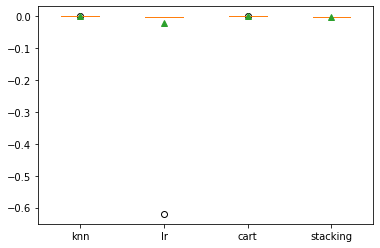

In [78]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

results, names = list(), list()
for name, model in models_dict.items():
	scores = evaluate_model(model, OHE_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Metrics for Ensemble

In [79]:
# Convert both y_train and y_test back to series
y_train = y_train.squeeze()
y_test = y_test.squeeze()

sr.fit(OHE_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('knn',
                               KNeighborsRegressor(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform')),
                              ('lr',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('cart',
                               DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_featu

In [80]:
# Compute MSE
def mse(y_predicted, y_true):
  return np.mean(np.square(y_predicted - y_true))

mse_training = mse(sr.predict(OHE_train), y_train)
mse_testing = mse(sr.predict(OHE_test), y_test)

print("training mse: {}, testing mse: {}".format(mse_training, mse_testing))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(mse_training), np.sqrt(mse_testing)))

training mse: 0.0020281070709889932, testing mse: 0.0025687858026878277
training rmse: 0.04503450977849091, testing rmse: 0.05068319053382322


In [81]:

# Compute R2 and adjusted R2
print("training R2: {}, testing R2: {}".format(sr.score(OHE_train, y_train), sr.score(OHE_test, y_test)))
print("training adjusted R2: {}, testing adjusted R2: {}".format(
    1 - (1-sr.score(OHE_train, y_train))*(len(y_train)-1)/(len(y_train)-OHE_train.shape[1]-1), 
    1 - (1-sr.score(OHE_test, y_test))*(len(y_test)-1)/(len(y_test)-OHE_test.shape[1]-1)))

training R2: 0.7958897836126303, testing R2: 0.7652490623810189
training adjusted R2: 0.7958164796809072, testing adjusted R2: 0.7650854764398632


In [82]:
# Calculate MAE
print("training MAE: {}, testing MAE: {}".format(
    mean_absolute_error(y_train, sr.predict(OHE_train)),
    mean_absolute_error(y_test, sr.predict(OHE_test)),    
))

training MAE: 0.016833928027365795, testing MAE: 0.023906840044900388


In [83]:
def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)

def MAPE(y_actual,y_predicted):
    mape = np.mean(np.abs((y_actual - y_predicted)/y_actual))*100
    return mape

In [84]:
# Calculate sMAPE
smape_training = smape(y_train, sr.predict(OHE_train))
smape_testing = smape(y_test, sr.predict(OHE_test))
print("training smape: {}, testing smape: {}".format(smape_training, smape_testing))

training smape: 8.256301001314462, testing smape: 11.916560245158102


In [85]:
# Calculate MAPE
mape_training = MAPE(y_train, sr.predict(OHE_train))
mape_testing = MAPE(y_test, sr.predict(OHE_test))
print("training mape: {}, testing mape: {}".format(mape_training, mape_testing))

training mape: inf, testing mape: 12.547360958293726


Text(0.5, 1.0, 'Residual plot')

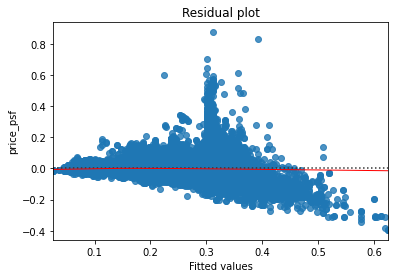

In [86]:
# Residual plot
sns.residplot(sr.predict(OHE_test).reshape(-1),y_test,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

0       -0.055003
1       -0.099519
2       -0.035832
3       -0.134985
4       -0.095271
           ...   
45949    0.015873
45950    0.009322
45951    0.006126
45952    0.005586
45953    0.002369
Name: price_psf, Length: 45954, dtype: float64


Text(0.5, 1.0, 'Normal Q-Q Plot')

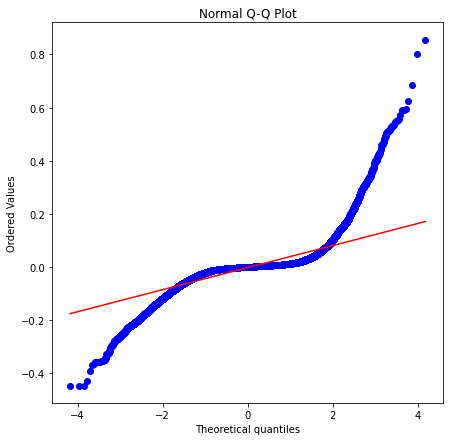

In [87]:
# QQ Plot
residuals = y_test - sr.predict(OHE_test).reshape(-1)
print(residuals)
plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

Text(0.5, 0, 'Fitted value')

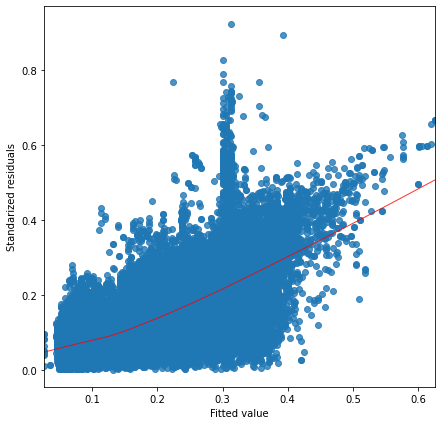

In [88]:
# Scale Location Plot
norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(sr.predict(OHE_test).reshape(-1).reshape(-1), norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")